# Acoustic scene classification



When interacting with mobile devices we expect relevant information to be presented with a minimum of input effort. 
What is relevant depends on the context in which we are acting.

If we are requesting a route information while sitting at a busstop we most probably are looking for directions for travel via a bus, while at a railway station we most probably are looking for a train connection.

One possibility for a device to identify the context is via geolocation information. But this information is may not be available inside buildings. An alternative approach is the analysis of ambient noise. This approach is referred to by the term acoustic scene classification.

*Acoustic scene classification (ACS) describes the "capability of a human or anartificial system to understand an audio context, either from an on-linestream or from a recording." (http://www.cs.tut.fi/sgn/arg/dcase2016/documents/workshop/Valenti-DCASE2016workshop.pdf).*

This workbook demonstrates how convolutional networks can be used for the classification.

We will be applying a pre-trained VGG-16 network with custom classifier applied on log-frequency power spectrograms.

# Data analysis and preparation

This project uses recordings made available as part of the DCASE (Detection and Classification of
Acoustic Scenes and Events) 2019 challenge (http://dcase.community/challenge2019/task-acoustic-scene-classification). The TAU Urban Acoustic Scenes 2019 development dataset contains recordings in 10 different settings (airport, indoor shopping mall, metro station, pedestrian street, stree traffic, tram, bus, metro, park) recorded in 10 cities. Each recording is 10 seconds long. The data files can be downloaded from https://zenodo.org/record/2589280 using data/download.sh.

*This workbook assumes that the extracted audio files are in directory data/TAU-urban-acoustic-scenes-2019-development/audio/ relative to this notebook.*

In [1]:
import IPython.display as ipd
import librosa, librosa.display
import math
import numpy as np
from collections import OrderedDict
import os
from PIL import Image, ImageDraw, ImageOps
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
import torch
from torch import nn, optim
from torchvision import datasets, transforms, models
import warnings
import wave

Let's analyze what the data looks like:

In [2]:
rawDataPath = 'data/TAU-urban-acoustic-scenes-2019-development/audio/'

def filenames2dataFrame(path):
    """Collect metadata of audio files
    
    path   - directory containing audio files
    return - data frame with metadata
    """
    
    data = []
    for filename in os.listdir(path):
        filepath = os.path.join(path, filename)
        head, tail = os.path.split(filename)
        parts = tail.split('-', 2)
        with wave.open(filepath, "rb") as file:
            sr = file.getframerate()
            duration = file.getnframes() / sr
        data.append( {
            'setting' : parts[0],
            'city' : parts[1],
            'recording' : parts[2],
            'duration' : duration,
            'sr' : sr
        })
    return pd.DataFrame(data)

df = filenames2dataFrame(rawDataPath)

print('Durations are in the range {} - {} s.\n'.format(df['duration'].min(), df['duration'].max()))
print('Sample rates are in the range {} - {} Hz.\n'.format(df['sr'].min(), df['sr'].max()))
print('There are a total of {} recordings.\n'.format(df.shape[0]))
print('Number of recordings per category:\n')
print(df.set_index(['setting', 'city', 'duration', 'sr']).count(level='setting'))
print(df.set_index(['setting', 'city', 'duration', 'sr']).count(level='city'))

Durations are in the range 9.999979166666666 - 10.000020833333334 s.

Sample rates are in the range 48000 - 48000 Hz.

There are a total of 14400 recordings.

Number of recordings per category:

                   recording
setting                     
airport                 1440
bus                     1440
metro                   1440
metro_station           1440
park                    1440
public_square           1440
shopping_mall           1440
street_pedestrian       1440
street_traffic          1440
tram                    1440
           recording
city                
barcelona       1421
helsinki        1447
lisbon          1440
london          1444
lyon            1440
milan           1440
paris           1452
prague          1440
stockholm       1456
vienna          1420


This looks benign:

* For each setting we have the same number of recordings.
* All recordings are roughly of same duration.
* All recordings use the same sample rate.

Let's listen to one of the files.

In [3]:
sr = 48000

def readAudioFile(filename, sr=48000):
    """Reads an audio file with default sampling rate 48000Hz
    
    filename - file to be read
    return - numpy.float32
    """
    x, sr = librosa.load(filename, sr=sr)
    return x


In [4]:
x = readAudioFile(rawDataPath + 'street_pedestrian-lyon-1162-44650-a.wav')
print('number of samples {}'.format(x.shape[0]))
ipd.Audio(x, rate=sr)

number of samples 479999


# Spectrograms

To analyze the audio files we can transform them into spectrograms (cf. https://en.wikipedia.org/wiki/Spectrogram). These show the frequency distribution for subsequent short time intervals.

## Mel spectrograms

A popular form of spectrograms are Mel spectrograms. The Mel scale is based on what humans perceive as equal pitch differences. The Mel scale defines how the frequency axis is scaled:

$$m = 2595 \log_{10}\left(1 + \frac{f}{700}\right)$$

The result of the scaling is that for high frequencies the scale is proportional to the logarithm of the frequency while low frequency (especially below 700 Hz) are compressed.

For speech analysis this scale is widely used.

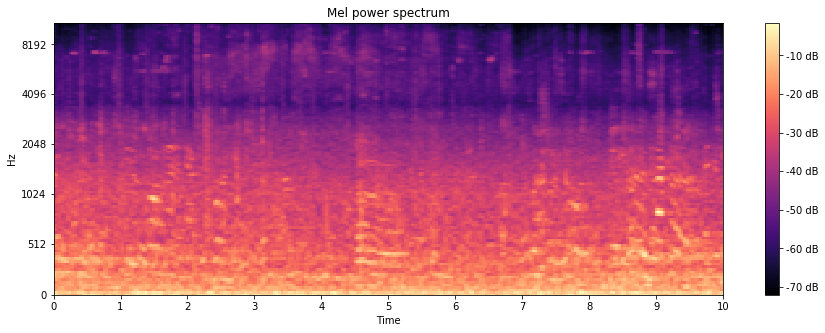

In [5]:
def melSpectrogram(x, sr=48000):
    """Draw mel spectrogram
    
    x  - samples
    sr - sample rate
    """
    
    hop_length = 1875 # This gives us 256 time buckets: 1875 = 10 * 48000 / 256
    n_fft = 8192 # This sets the lower frequency cut off to 48000 Hz / 8192 * 2 = 12 Hz
    S = librosa.feature.melspectrogram(x, sr=sr, n_fft=n_fft, hop_length=hop_length)
    logS = librosa.power_to_db(abs(S))
    plt.figure(figsize=(15, 5))
    librosa.display.specshow(logS, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel power spectrum')
    
melSpectrogram(x)

* Most of the audio power is concentrated on low frequencies.
* A lot of the structure that we can see is in the low frequencies.
* High frequencies seem to be filtered out.

Ambiant sound can contain a lot of low frequency sounds, e.g.

* Automobile motors run at 600 - 6000 rpm. With four cylinders that results in a 40 - 400 Hz exhaust frequency.
* Ventilators typically run at 750 - 3000 rpm.

These are the frequencies that are compressed by the Mel scale.

When the running speed of machines is changed this will move much of the sound spectrum by the same factor. While the Mel scale distorts this shift for low frequencies the spectrum would be simply translated along the frequency axis on a pure logarithimic scale by the same distance.

**So using a logarithmic scale for the the analysis seems more appropriate.**

Let's create a log-frequency power spectrogram (also referred to as constant-Q power spectrogram).

## Log-frequency spectrograms

In [6]:
def logFrequencySpectrogram(x, sr=48000):

    hop_length = 1024 # must be a multiple of 2^number_of_octaves
    n_bins = 256 # number of bins
    bins_per_octave = 24 # a quarter note
    fmin = 10 # 10 Hz
    fmax = fmin * math.pow(2., n_bins / bins_per_octave)
    C = librosa.cqt(x, sr=sr, fmin = 10, hop_length=hop_length, n_bins= n_bins,
                    bins_per_octave = bins_per_octave)
    logC = librosa.power_to_db(np.abs(C))
    return logC

def drawLogFrequencySpectrogram(x, sr=48000):
    logC = logFrequencySpectrogram(x, sr)
    plt.figure(figsize=(15, 5))
    librosa.display.specshow(logC, sr=sr, x_axis='time', y_axis='cqt_hz', fmin = 10, bins_per_octave = 24)
    plt.colorbar(format='%+2.0f dB')
    plt.title('Constant-Q power spectrum')
    plt.show()

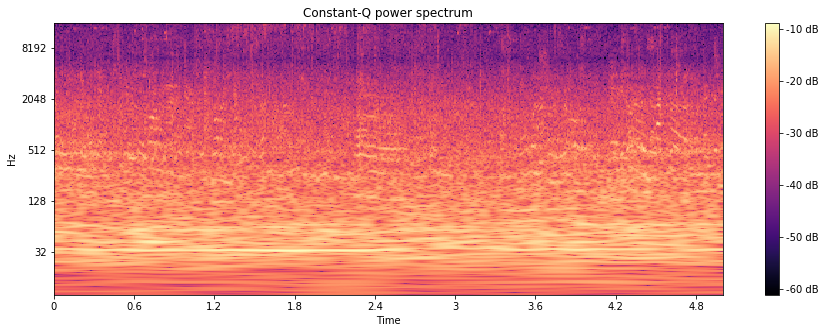

In [7]:
drawLogFrequencySpectrogram(x)

* With the log-frequency spectrogram the structure fo low the frequency noise is clearly visible.
* The audio power is more distributed over the frequency intervals.
* Yet high frequencies are still underrepresented.

## Pre-emphasis

The high frequency can be emphasized using a filter.

In [8]:
def preEmphasis(x, alpha=.97):
    """emphasise high frequencies
    
    This filter mixes the signal with its first derivative:
    
    y[n] = (x[n] - alpha * x[n-1]) / (1 - alpha)

    Reference:
    Haytham Fayek,
    "Speech Processing for Machine Learning: Filter banks, Mel-Frequency Cepstral
    Coefficients (MFCCs) and What's In-Between",
    https://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html
    
    The implementation by Haytham Fayek lacks a good first value. This
    implementation uses x[-1] = 2 * x[0] - x[1].
    Further to keep the amplitudes for low frequencies unchanged the output signal
    is divided by (1 - alpha).

    x - original signal
    alpha - proportion of the output signal that comes from the first derivative
    """
    return np.append((1 - 2 * alpha) * x[0] + alpha * x[1],
                     x[1:] - alpha * x[:-1]) / (1 - alpha)

p = preEmphasis(x, .97)
ipd.Audio(p, rate=sr)

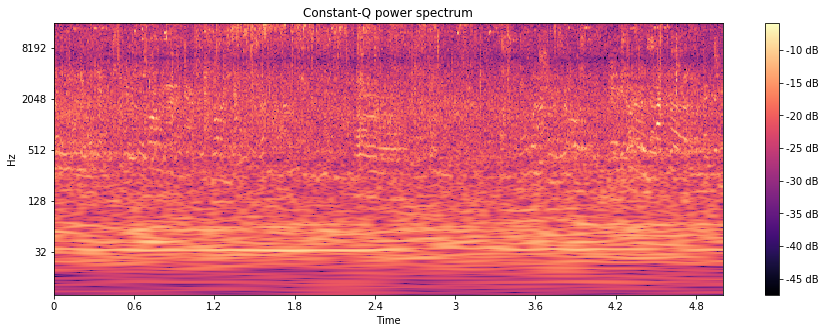

In [9]:
drawLogFrequencySpectrogram(p)

The spectogram can easily be converted to a black and white image.

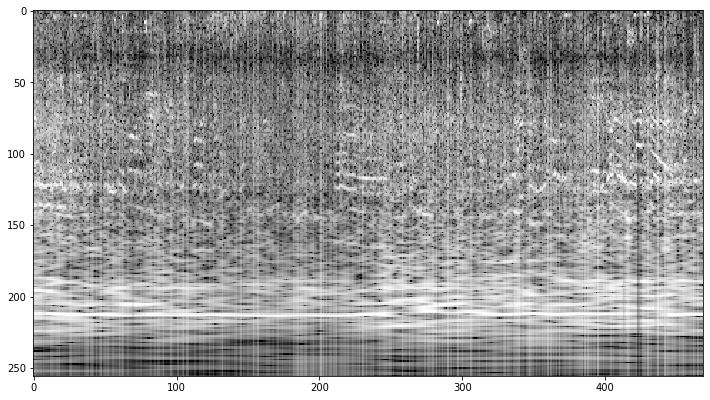

In [10]:
def bwLogFrequencySpectrogram(x, sr=48000):
    """Create a log-requency spectrogram as an image
    
    x      - samples
    return - spectrogram
    """
    logC = logFrequencySpectrogram(p);
    scaler = MinMaxScaler(feature_range=(0, 255))
    logC = scaler.fit_transform(logC)
    img = Image.fromarray(logC)
    img = img.transpose(Image.FLIP_TOP_BOTTOM)
    return img

def drawImage(img):
    plt.figure(figsize=(12, 7))
    plt.imshow(img, cmap=plt.cm.gray)
        

drawImage(bwLogFrequencySpectrogram(p))


The accompanying script convert.py can be used to convert all recordings to spectrograms

    data/TAU-urban-acoustic-scenes-2019-development/audio/ data/spectrograms/

The script saves the data in directory structure like

    |- airport
    ||- barcelona
    ||- helsinki
    |...
    |- bus
    ||- barcelona
    ||- helsinki
    ...

*In the following it is assumed that the spectrograms are available in directory data/spectrograms relative to this notebook.*

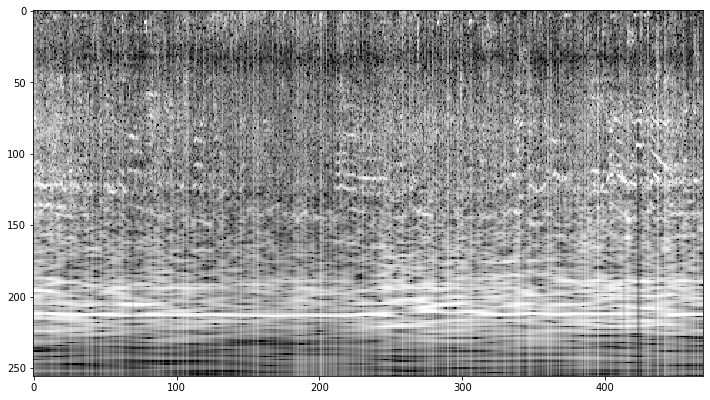

In [11]:
# Let's check
img = Image.open('data/spectrograms/street_pedestrian/lyon/1162-44650-a.png')
drawImage(img)
# You should see the same image as above

# Modelling

## Data augmentation

The number of recordings per category are rather small. To avoid overfitting data augmentation should be applied.

For image data a large variety of transformtions can be used for augmentation. These include for instance random resized cropping, rotations, and flipping (see for instance https://github.com/aleju/imgaug).

Not all make sense for spectrograms,eg. rotations. Reasonable transformations are:

* changes in pitch
* changes in tempo (cf. https://en.wikipedia.org/wiki/Tempo)
* translation in time (aka. time warping)


In [12]:
class RandomAudioTransform:
    """Randomly transform short time spectrogram

    The spectrogram is transformed randomly in three ways:

    * The spectrogram frequencies are transposed randomly.
    * The tempo is randomly changed.
    * A random sampling window in time is chosen.

    size             - target image size of the spectrogram
    octaves          - number of octaves by which to shift spectrogram
    bins_per_octaves - number of image pixels per octave
    dilation         - maximum relative increment of the tempo
    sample_size      - size of the time window in relation to the whole
                       spectrogram
    random           - True: use random values, False: replace random values by
                       fixed values
    """

    def __init__(self, size=224, octaves=.5, bins_per_octave=24, dilation=0.25,
                 sample_size=.5, random=True):
        """Construct new RandomAudioTransform
        """

        self.size = size
        self.octaves = octaves
        self.bins_per_octave = bins_per_octave
        self.dilation = dilation
        self.sample_size = sample_size
        self.random = random

    def rand(self):
        """Generate random number from interval [0., 1.[
        """

        if self.random:
            return random.random()
        return .5

    def __call__(self, img):
        """Transform a spectrogram provided as image

        img    - image to transform
        Return - transformed image
        """

        # Stretch the time axis according sample size and time dilation
        width = int((1. + self.dilation * self.rand())
                    * self.size / self.sample_size)
        img = img.resize(size=[width, img.size[1]], resample=Image.BICUBIC)
        # Take sample from image
        alpha = self.octaves * self.bins_per_octave / (img.size[0] - self.size)
        center = [self.rand(), (1 - alpha) * .5 + alpha * self.rand()]
        img = ImageOps.fit(img, size=[self.size, self.size],
                           method=Image.BICUBIC, centering=center)
        return img

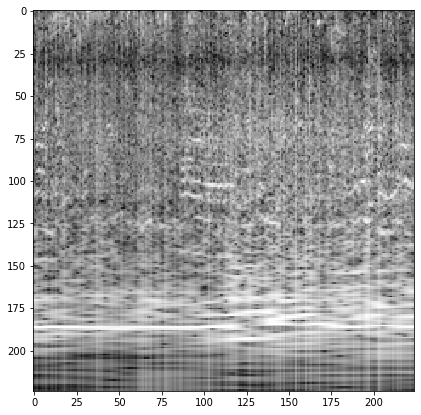

In [13]:
# By default a random 5 second sample of the spectrogram shifted by up to .5 octavs is created.
# Just reexecute this cell to see the random changes.
transform = RandomAudioTransform()
img = Image.open('data/spectrograms/street_pedestrian/lyon/1162-44650-a.png')
drawImage(transform(img))
pass

In "SpecAugment: A Simple Augmentation Method for Automatic Speech Recognition", 2019, Zoph et.al suggest masking frequency bands for augmentation (https://ai.google/research/pubs/pub48482/, https://arxiv.org/pdf/1904.08779.pdf).

In [14]:
class FrequencyMask:
    """Randomly mask frequency band in short time spectrogram

    The spectrogram is transformed randomly in three ways:

    * The spectrogram frequencies are transposed randomly.
    * The speed is randomly changed.
    * A random sampling window in time is chosen.

    max_width        - maximum portion of all frequencies that will be masked
    """

    def __init__(self, max_width = .2):
        """Construct new FrequencyMask
        """

        self.max_width = max_width

    def __call__(self, img):
        """Transform a spectrogram provided as as image

        img    - image to transform
        Return - transformed image
        """
        width, height = img.size
        mask_height = height * self.max_width * random.random()
        ymin = math.floor((height - mask_height) * random.random())
        ymax = math.floor(mask_height + ymin)
        draw = ImageDraw.Draw(img)
        draw.rectangle(((0, ymin), (width - 1, ymax)), fill=(127, 127, 127))
        return img

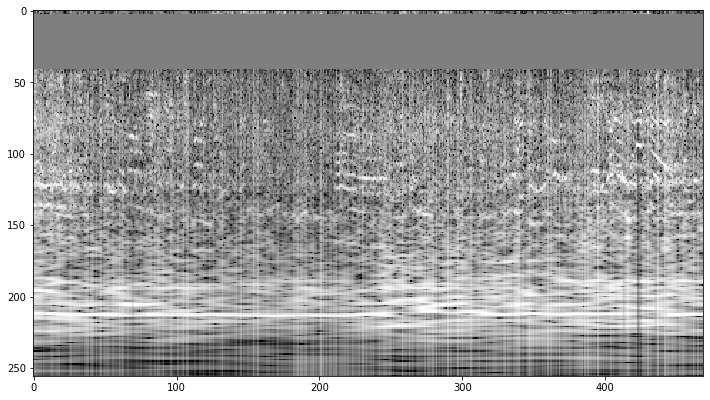

In [15]:
# A random frequency band is masked.
# Just reexecute this cell to see the random changes.
transform = FrequencyMask()
img = Image.open('data/spectrograms/street_pedestrian/lyon/1162-44650-a.png')
drawImage(transform(img))
pass

## Train, validation, and test data sets

In machine learning we should use separate data sets for training, validation and testing. Accompanying script split.py is provided for executing the split with using a 80:20:20 ratio on each setting-city combination:

    python3 ./split.py data/spectrograms data/splitted

*In the following it is assumed that the splitted data set is available in data/splitted.*

In [16]:
# Let's check (assuming Linux as operating system). The result should be close to 8640, 2880, 2880
print("train: {}".format(os.popen("find data/splitted/train -name '*.png' | wc -l").read()))
print("valid: {}".format(os.popen("find data/splitted/valid -name '*.png' | wc -l").read()))
print("test: {}".format(os.popen("find data/splitted/test -name '*.png' | wc -l").read()))

train: 8601

valid: 2901

test: 2898



# Neural network training

Using a pre-trained network as starting point very much simplifies finding good solutions. One example of a pre-tained network for image recognition is VGG16 (Karen Simonyan, Andrew Zisserman, "Very Deep Convolutional Networks for Large-Scale Image Recognition", 2014, https://arxiv.org/abs/1409.1556) delivered with the torchvision package.

I have tested both VGG16 and VGG19 in this project but found no benefit in using VGG19 which has some additional layers.

### Transforms

In [17]:

# This normalization has been used for pre-training the VGG16 model.
transform_norm = transforms.Normalize(
    [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
train_transforms = transforms.Compose([RandomAudioTransform(
    random=True),
                                       FrequencyMask(.2),
                                       transforms.ToTensor(),
                                       transform_norm])

test_transforms = transforms.Compose([RandomAudioTransform(
    random=False),
                                      transforms.ToTensor(),
                                      transform_norm])


### Data loaders

In [18]:
data_dir = 'data/splitted'

train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')
valid_dir = os.path.join(data_dir, 'valid')

train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
valid_data = datasets.ImageFolder(valid_dir, transform=test_transforms)
test_data = datasets.ImageFolder(test_dir, transform=test_transforms)

class_to_idx = test_data.class_to_idx

# The batch sizes below fit into the 6GB of an Nvidia GTX 1060.
trainloader = torch.utils.data.DataLoader(
    train_data, batch_size=32, shuffle=True)
validloader = torch.utils.data.DataLoader(
    valid_data, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(
    test_data, batch_size=32, shuffle=True)

### Model

In [19]:
def get_in_features(model):
    """Get the number of in_features of the classifier
    """
    in_features = 0
    for module in model.classifier.modules():
        try:
            in_features = module.in_features
            break
        except AttributeError:
            pass
    return in_features

def create_classifier(model, out_features, hidden_units=512):
    """Create the classifier
    """
    classifier = nn.Sequential(OrderedDict([
        ('fc1', nn.Linear(get_in_features(model), hidden_units)),
        ('relu1', nn.ReLU(inplace=True)),
        ('drop1', nn.Dropout(.5)),
        ('fc2', nn.Linear(hidden_units, hidden_units)),
        ('relu2', nn.ReLU(inplace=True)),
        ('drop2', nn.Dropout(.5)),
        ('fc3', nn.Linear(hidden_units, out_features)),
        ('output', nn.LogSoftmax(dim=1))
    ]))
    model.classifier = classifier


In [20]:
def load_model(classifier_only = True):
    """ Load the pretrained model
    
    classifier_only - change classifier parameters only
    """
    
    method_to_call = getattr(models, 'vgg16')
    model = method_to_call(pretrained=True)

    if classifier_only:
        # Do not update model parameters
        for param in model.parameters():
            param.requires_grad = False

    # Add our own classifier
    create_classifier(model, out_features=len(class_to_idx), hidden_units=512)
    
    return model

model = load_model()

In [21]:
def check_accuracy(model, testloader, device='cuda', print_every=40):
    """Check the accuracy of the model"""
    correct = 0
    total = 0
    steps = 0
    expected = []
    actual = []

    model.to(device)
    model.eval()

    with torch.no_grad():
        for inputs, labels in testloader:
            steps += 1
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            for label in labels.tolist():
                expected.append(label)
            for prediction in predicted.tolist():
                actual.append(prediction)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            print('-', end='', flush=True)
            if steps % print_every == 0:
                print()
    accuracy = 100 * correct / total    
    print('\nAccuracy: {:.4f} %'.format(accuracy))
    print('Confusion matrix')
    print(confusion_matrix(expected, actual))
    return accuracy

In [22]:
def save_checkpoint(path, model, optimizer, class_to_idx):
    """Save a checkpoint"""
    model.class_to_idx = class_to_idx
    warnings.filterwarnings("ignore", category=UserWarning)
    torch.save({'model': model,
                'optimizer': optimizer}, path)
    warnings.filterwarnings("default", category=UserWarning)

In [23]:
def do_deep_learning(model, criterion, optimizer, epochs=1, device='cuda', print_every=40):
    """Execute training steps
    
    Training is discontinued if there is no improvement for 10 epochs.
    
    """

    model.to(device)
    model.train()
    
    best_accuracy = 0.0
    worse_count = 0
    
    for epoch in range(epochs):
        running_loss = 0
        steps = 0
        for inputs, labels in trainloader:
            steps += 1

            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            # Forward and backward passes
            outputs = model.forward(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            print('.', end='', flush=True)
            if steps % print_every == 0:
                print("Epoch: {}/{}, ".format(epoch + 1, epochs),
                      "Loss: {:.4f}".format(running_loss/print_every))
                running_loss = 0

        while steps % print_every != 0:
            print(' ', end='')
            steps += 1
        print("Epoch {} completed".format(epoch + 1))
        accuracy = check_accuracy(model, validloader)
        
        if accuracy >= best_accuracy:
            best_accuracy = accuracy
            worse_count = 0
            # To avoid disk wear the checkpoint is saved in the
            # /tmp directory which hopefully is a RAM disk.
            save_checkpoint('/tmp/checkpoint.pt', model, optimizer, class_to_idx)
        else:
            worse_count += 1
            if worse_count == 10:
                print("No improvement for 10 epochs")
                break

    print()            

In [24]:
# To make this reproducible let'use fixed random seeds
torch.manual_seed(8259)
random.seed(6745)

optimizer = optim.Adam(model.classifier.parameters(), lr=.001)
criterion = nn.NLLLoss()
do_deep_learning(model, criterion, optimizer, epochs=200)


........................................Epoch: 1/200,  Loss: 2.3941
........................................Epoch: 1/200,  Loss: 2.0572
........................................Epoch: 1/200,  Loss: 1.8963
........................................Epoch: 1/200,  Loss: 1.8545
........................................Epoch: 1/200,  Loss: 1.8011
........................................Epoch: 1/200,  Loss: 1.7795
.............................           Epoch 1 completed
----------------------------------------
----------------------------------------
-----------
Accuracy: 45.1913 %
Confusion matrix
[[  0   2   1   4   3   3 193  85   0   0]
 [  0 278   1   2   1   0   0   2   1   5]
 [  0  85  73  45  19   0  18  13   1  37]
 [  0  27  22  41  16   5 118  34  17  10]
 [  0   6   0   8 242   4   0  11  15   4]
 [  0   2   1  14  51  30  59 104  28   1]
 [  0   1   3  12   0   1 225  48   0   0]
 [  0   3   0   8  21  10 100 138   8   1]
 [  0   7   1  12  27  14   7  31 189   2]
 [  0 112  26  2

........................................Epoch: 9/200,  Loss: 1.0213
........................................Epoch: 9/200,  Loss: 1.0518
........................................Epoch: 9/200,  Loss: 1.0211
........................................Epoch: 9/200,  Loss: 1.0524
........................................Epoch: 9/200,  Loss: 1.0023
........................................Epoch: 9/200,  Loss: 1.1424
.............................           Epoch 9 completed
----------------------------------------
----------------------------------------
-----------
Accuracy: 63.9090 %
Confusion matrix
[[161   0   0  10   1  27  50  41   0   1]
 [  0 259   3   5   1   0   0   1   1  20]
 [  7  17  98  35   2   7   8   4   1 112]
 [ 20   7   3 147   3  12  35  39   2  22]
 [  0   1   0   3 250  21   0   3   7   5]
 [ 23   0   0   9  20 141  21  66  10   0]
 [ 33   0   2  11   0   5 190  49   0   0]
 [ 26   1   0   6   8  36  17 190   3   2]
 [  1   1   0   6  20  45   1  23 188   5]
 [  2  20   5  2

........................................Epoch: 17/200,  Loss: 0.9784
........................................Epoch: 17/200,  Loss: 0.9514
........................................Epoch: 17/200,  Loss: 0.9579
........................................Epoch: 17/200,  Loss: 0.9635
........................................Epoch: 17/200,  Loss: 0.9341
........................................Epoch: 17/200,  Loss: 0.9784
.............................           Epoch 17 completed
----------------------------------------
----------------------------------------
-----------
Accuracy: 66.0807 %
Confusion matrix
[[185   0   2   8   3  25  23  43   1   1]
 [  0 270   9   0   3   0   0   0   1   7]
 [  6  22 175  12   5   6   3   4   2  56]
 [ 41  18  24 114   4  14  18  29  13  15]
 [  2   3   0   2 262  13   0   1   5   2]
 [ 20   0   2   1  29 159  10  55  13   1]
 [ 57   2   2  13   0   7 164  44   1   0]
 [ 27   4   1   6   9  51   9 177   4   1]
 [  0   1   0   1  27  42   0   9 209   1]
 [  3  32

........................................Epoch: 25/200,  Loss: 0.9253
........................................Epoch: 25/200,  Loss: 0.8840
........................................Epoch: 25/200,  Loss: 0.8845
........................................Epoch: 25/200,  Loss: 0.9126
........................................Epoch: 25/200,  Loss: 0.9135
........................................Epoch: 25/200,  Loss: 0.8737
.............................           Epoch 25 completed
----------------------------------------
----------------------------------------
-----------
Accuracy: 66.3220 %
Confusion matrix
[[241   0   0  10   2   6  18  12   1   1]
 [  0 254  20   5   1   0   1   0   2   7]
 [  9  10 204  20   3   4   3   3   0  35]
 [ 37   8  26 147   3   5  28  20   4  12]
 [  3   0   5   3 247  19   0   1  10   2]
 [ 58   0   2   2  20 111  23  48  25   1]
 [ 83   0   2  10   0   2 181  12   0   0]
 [ 63   1   2   7   7  20  48 134   6   1]
 [  2   1   1   2  17  16   0   6 243   2]
 [  6  25

........................................Epoch: 33/200,  Loss: 0.8574
........................................Epoch: 33/200,  Loss: 0.8498
........................................Epoch: 33/200,  Loss: 0.8929
........................................Epoch: 33/200,  Loss: 0.8570
........................................Epoch: 33/200,  Loss: 0.8570
........................................Epoch: 33/200,  Loss: 0.8382
.............................           Epoch 33 completed
----------------------------------------
----------------------------------------
-----------
Accuracy: 64.7018 %
Confusion matrix
[[202   0   0   4   2  22  33  28   0   0]
 [  0 233  33   6   3   0   2   6   2   5]
 [  9   5 183  33   7   9  12   9   1  23]
 [ 43   4  10 120   3   5  48  40   8   9]
 [  3   0   0   3 239  21   0   2  22   0]
 [ 24   0   1   1  10 139  20  72  22   1]
 [ 52   0   0   2   0   4 190  42   0   0]
 [ 33   0   0   1   4  32  18 197   3   1]
 [  1   1   0   1   8  39   0  13 223   4]
 [  8  15

........................................Epoch: 41/200,  Loss: 0.8315
........................................Epoch: 41/200,  Loss: 0.7960
........................................Epoch: 41/200,  Loss: 0.8330
........................................Epoch: 41/200,  Loss: 0.8220
........................................Epoch: 41/200,  Loss: 0.8066
........................................Epoch: 41/200,  Loss: 0.8412
.............................           Epoch 41 completed
----------------------------------------
----------------------------------------
-----------
Accuracy: 67.0114 %
Confusion matrix
[[243   0   0   6   1  13  11  16   0   1]
 [  0 264   8   1   2   0   0   2   2  11]
 [ 15  14 170  21   6   3   6   3   1  52]
 [ 58   8  18 127   5   7  30  16   6  15]
 [  4   0   0   0 257  22   0   0   6   1]
 [ 39   0   1   1  19 143  19  56  11   1]
 [ 99   0   1   4   0   3 170  13   0   0]
 [ 69   3   1   4   4  32  20 154   2   0]
 [  2   1   1   0  20  28   2  11 219   6]
 [  9  21

........................................Epoch: 49/200,  Loss: 0.7863
........................................Epoch: 49/200,  Loss: 0.7805
........................................Epoch: 49/200,  Loss: 0.7751
........................................Epoch: 49/200,  Loss: 0.7991
........................................Epoch: 49/200,  Loss: 0.8230
........................................Epoch: 49/200,  Loss: 0.8240
.............................           Epoch 49 completed
----------------------------------------
----------------------------------------
-----------
Accuracy: 68.4936 %
Confusion matrix
[[187   0   4  23   7  19  27  22   2   0]
 [  0 248  25   2   3   0   0   0   4   8]
 [  2   3 223  21   3   2   3   3   4  27]
 [ 12   6  22 186   7   8  18  16   5  10]
 [  0   0   0   3 267   6   0   2  12   0]
 [ 23   0   4   6  36 135   9  41  35   1]
 [ 48   0   1  27   0   5 176  30   3   0]
 [ 29   1   3  15  10  43  23 154   9   2]
 [  2   1   0   1  28   8   1   5 243   1]
 [  2  14

........................................Epoch: 57/200,  Loss: 0.7401
........................................Epoch: 57/200,  Loss: 0.7642
........................................Epoch: 57/200,  Loss: 0.8141
........................................Epoch: 57/200,  Loss: 0.7915
........................................Epoch: 57/200,  Loss: 0.7865
........................................Epoch: 57/200,  Loss: 0.7770
.............................           Epoch 57 completed
----------------------------------------
----------------------------------------
-----------
Accuracy: 68.1144 %
Confusion matrix
[[206   0   0  12   7  14  22  29   1   0]
 [  0 267   8   4   1   0   0   0   3   7]
 [  7  11 126  49   4   5   5   6   2  76]
 [ 21   6   5 178   3  11  23  22   7  14]
 [  3   0   0   1 272   9   0   1   4   0]
 [ 24   0   0   4  30 143  11  59  17   2]
 [ 65   0   0  15   0   8 172  29   0   1]
 [ 34   3   0  10  12  33  13 175   7   2]
 [  2   1   0   4  21  26   0   8 227   1]
 [  3  22

........................................Epoch: 65/200,  Loss: 0.7553
........................................Epoch: 65/200,  Loss: 0.7642
........................................Epoch: 65/200,  Loss: 0.7776
........................................Epoch: 65/200,  Loss: 0.8055
........................................Epoch: 65/200,  Loss: 0.7804
........................................Epoch: 65/200,  Loss: 0.7665
.............................           Epoch 65 completed
----------------------------------------
----------------------------------------
-----------
Accuracy: 68.6660 %
Confusion matrix
[[222   0   4   8   5  31   2  17   1   1]
 [  0 268   8   3   0   0   0   0   2   9]
 [  3  13 203  14   2   6   1   2   4  43]
 [ 37   7  28 142   6  11   6  22  14  17]
 [  1   0   3   1 260  10   0   1  13   1]
 [ 21   0   2   2  25 188   6  29  15   2]
 [103   0   1  15   0  14 122  31   3   1]
 [ 35   3   1   7   8  76   3 144   7   5]
 [  2   1   0   0  18  23   0   2 243   1]
 [  2  25

# Evaluation

The best fitting model has been saved as checkpoint. Load it and check the accuracy against the test data set.

In [25]:
# To avoid disk wear the checkpoints have been saved in the /tmp directory
# which hopefully is a RAM disk. Copy the current checkpoint to our directory.
os.popen("cp /tmp/checkpoint.pt checkpoint.pt 2>&1 && echo ok").read()

'ok\n'

In [26]:
def load_checkpoint(path='checkpoint.pt'):
    """Reload model from checkpoint
    """
    checkpoint = torch.load(path)
    model = checkpoint['model']
    return model

In [27]:
# Check the accuary using the test data
model  = load_checkpoint('checkpoint.pt')
class_to_idx = model.class_to_idx
check_accuracy(model, testloader)
pass

----------------------------------------
----------------------------------------
-----------
Accuracy: 68.9786 %
Confusion matrix
[[215   0   0   3   1  17  30  17   6   1]
 [  0 256   2   4   1   1   1   1   3  21]
 [  6  15 153  33   1   9   0   1   3  68]
 [ 32   6  17 171   4  18  11  12   4  15]
 [  0   1   0   1 252  21   0   5   9   1]
 [ 25   1   1   3  26 165  15  29  22   3]
 [ 51   0   0   7   0  16 197  19   0   0]
 [ 35   0   1   8  10  63  19 146   6   1]
 [  3   1   0   3  20  26   1   4 228   4]
 [  3  10  29  18   3   6   0   4   1 216]]


The columns in the confusion matrix correspond to the predicted categories. The rows to the actual categories. Find the labels for the rows an columns below.

So a the noise inside a bus is easily recognized. But the sound of a street with pedestrians is easily mistake for a public square.

In [28]:
class_to_idx

{'airport': 0,
 'bus': 1,
 'metro': 2,
 'metro_station': 3,
 'park': 4,
 'public_square': 5,
 'shopping_mall': 6,
 'street_pedestrian': 7,
 'street_traffic': 8,
 'tram': 9}

## Prediction

Let's use the model to make a prediction

In [29]:
class Predict:
    """Image classifier"""

    def __init__(self):
        """Constructor"""
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.image = None
        self.category_names = None
        self.top_k = 5

    def classify(self, image_file_name, checkpoint_file_name,
                 category_names_file_name = None):
        """classify an image"""
        self.load_checkpoint(checkpoint_file_name)
        self.load_image(image_file_name)
        if category_names_file_name is not None:
            self.load_category_names(category_names_file_name)
        probs, categories = self.infer(self.top_k)
        self.output(probs, categories)
        self.draw_prediction(probs, categories)

    def infer(self, top_k):
        """Infer the classes"""
        self.model.to(self.device)
        self.model.eval()
        inputs = torch.stack((self.image,))
        inputs = inputs.to(self.device)

        with torch.no_grad():
            outputs = self.model(inputs)

        outputs = outputs.to("cpu")
        probs, indices = outputs.topk(top_k)
        probs = probs.exp()
        probs = probs.tolist()[0]
        indices = indices.tolist()[0]
        categories = [self.idx_to_class[index] for index in indices]
        return probs, categories

    def load_checkpoint(self, checkpoint_file_name):
        """Load checkpoint from file"""
        checkpoint = torch.load(checkpoint_file_name, map_location={'cuda:0': 'cpu'})
        self.model = checkpoint['model']
        self.criterion = nn.NLLLoss()
        class_to_idx = self.model.class_to_idx
        self.idx_to_class = {value : key
                             for key, value in class_to_idx.items()}

    def load_image(self, image_file_name):
        """Load image from file"""
        self.image = Image.open(image_file_name).convert('RGB')
        self.image = self.normalize_image(self.image)

    def normalize_image(self, image):
        """Normalize image"""
        return test_transforms(image)

    def output(self, probs, categories):
        """Output category names and propabilities"""
        if self.category_names is not None:
            categories = [self.category_names[category]
                          for category in categories]
            category_title = 'Category Name'
        else:
            category_title = 'Category'
        max_len = max([len(category) for category in categories])
        max_len = max(max_len, len(category_title))
        print('{:>{}} | {}'.format(category_title, max_len, 'Propability'))
        print('{:>{}}-+-{}'.format('-' * max_len, max_len, '-----------'))
        for i in range(len(probs)):
            print('{:>{}} | {:.4f}'.format( categories[i], max_len, probs[i]))

    def draw_prediction(self, propabilities, categories,
                        true_category = '', title = 'Prediction'):

        fig, plot = plt.subplots(nrows=1, ncols=1, figsize=(7,5))
        fig.tight_layout()
        fig.suptitle(title, fontsize=20, y=1.05)

        margin = 0.05
        n_cat = len(categories)
        ind = np.arange(n_cat)
        width = (1. - 2. * margin) / n_cat
    
        plot.barh(ind, propabilities[::-1], height = .8)
        plot.set_yticks(ind + margin)
        plot.set_yticklabels(categories[::-1], fontsize=16)
        plot.set_xlabel('propability')
            
    def set_device(self, device_name):
        """Set the cuda device"""
        self.device = torch.device(device_name)

    def set_top_k(self, top_k):
        """Set number of categories to output"""
        self.top_k = top_k
        

In [30]:
# Can you identify the sound?
x = readAudioFile(rawDataPath + 'bus-milan-1115-42136-a.wav')
ipd.Audio(x, rate=sr)

      Category | Propability
---------------+------------
           bus | 0.7074
         metro | 0.2347
 metro_station | 0.0520
 shopping_mall | 0.0058
street_traffic | 0.0000


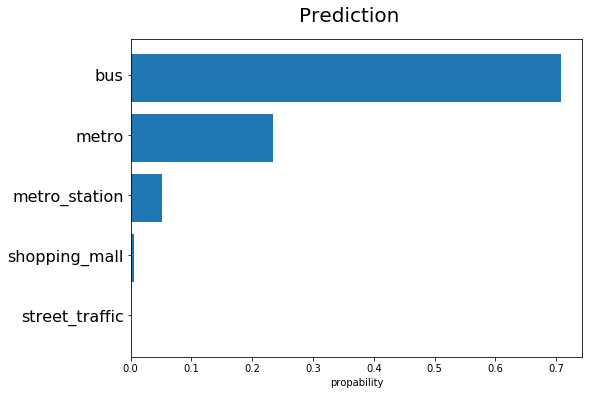

In [31]:
# Check yout guess against the prediction.
predict = Predict()
predict.classify('data/spectrograms/bus/milan/1115-42136-a.png', 'checkpoint.pt', None)

# Deployment

The project folders contains two standalone Python programs.

* train.py can be used to retrain the model on a new data set.
* predict.py uses a saved checkpoint for predictions. Similar code could be used to create a web service for classification.

# Conclusion

A workflow for classifying ambiant sound was demonstrated:

* correcting sound quality by using a pre-emphasis filter
* convert sound files to spectrograms
* split the dataset into training, validation, and testing data
* train a convolutional neural network using data augmentation
* use the trained network for prediction

Though a network was used that is not specificically built for this classification task respectable accuracy rates were be achieved.

Directions for further investigation could be 

* a grid search to optimize the parameters of the augmentation transforms
* testing further augmentation techniques like adding noise
* design of a more specific neural network.